In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
os.makedirs('sim1')
import shutil
src="/kaggle/input/skin-diseases-image-dataset"
des="/kaggle/working/sim1"
#shutil.copytree(src="/kaggle/input/skin-diseases-image-dataset",dst="/kaggle/working/sim")
if os.path.exists(des):
        shutil.rmtree(des)
        shutil.copytree(src, des)

In [3]:
shutil.rmtree("/kaggle/working/sim1/IMG_CLASSES/3. Atopic Dermatitis - 1.25k")

In [4]:
loc="/kaggle/working/sim1/IMG_CLASSES"
!pip install split_folders
import splitfolders
import os
os.makedirs('output')
os.makedirs('output/train')
os.makedirs('output/val')
os.makedirs('output/test')
splitfolders.ratio(loc,output = "output",seed = 42,ratio = (0.80,.1,.1))

Copying files: 25896 files [01:02, 416.76 files/s] 


In [5]:
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dir="./output/train"
test_dir="./output/test"
val_dir="./output/val"
train_data=image_dataset_from_directory(train_dir,batch_size=32,image_size=(224,224),label_mode='categorical',shuffle=True,seed=42)
test_data=image_dataset_from_directory(test_dir,batch_size=32,image_size=(224,224),label_mode='categorical',shuffle=False,seed=42)
val_data=image_dataset_from_directory(val_dir,batch_size=32,image_size=(224,224),label_mode='categorical',shuffle=False,seed=42)

Found 20714 files belonging to 9 classes.
Found 2596 files belonging to 9 classes.
Found 2586 files belonging to 9 classes.


In [7]:
class_names=train_data.class_names
class_count=len(class_names)
print(len(class_names))
print(class_names)
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size = tf.data.AUTOTUNE)

9
['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


In [8]:
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
model_name='EfficientNetB2'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
x=base_model.output
#x=layers.GlobalAvgPool2D(name = "pooling_layer")(x)
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=42)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(tf.keras.optimizers.Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

31790344/31790344 [==============================] - 2s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [10]:
history=model.fit(train_data,epochs = 10,
                     validation_data = val_data)

Epoch 1/10


2023-03-27 16:40:13.875820: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


648/648 [==============================] - 278s 341ms/step - loss: 5.9304 - accuracy: 0.6586 - val_loss: 2.4932 - val_accuracy: 0.7390
Epoch 2/10
648/648 [==============================] - 218s 335ms/step - loss: 1.5792 - accuracy: 0.7672 - val_loss: 1.0573 - val_accuracy: 0.7823
Epoch 3/10
648/648 [==============================] - 228s 350ms/step - loss: 0.8650 - accuracy: 0.8263 - val_loss: 0.8271 - val_accuracy: 0.8148
Epoch 4/10
648/648 [==============================] - 221s 339ms/step - loss: 0.6535 - accuracy: 0.8763 - val_loss: 0.7695 - val_accuracy: 0.8279
Epoch 5/10
648/648 [==============================] - 222s 340ms/step - loss: 0.5166 - accuracy: 0.9168 - val_loss: 0.7153 - val_accuracy: 0.8399
Epoch 6/10
648/648 [==============================] - 229s 352ms/step - loss: 0.4268 - accuracy: 0.9387 - val_loss: 0.7212 - val_accuracy: 0.8469
Epoch 7/10
648/648 [==============================] - 218s 335ms/step - loss: 0.3676 - accuracy: 0.9536 - val_loss: 0.6844 - val_accura

In [11]:
pred_probs = model.predict(test_data)
pred_classes = pred_probs.argmax(axis =1)
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
from sklearn.metrics import classification_report
print("Classification report\n",classification_report(y_labels,pred_classes))

82/82 [==============================] - 15s 159ms/step
Classification report
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       169
           1       0.68      0.80      0.74       211
           2       0.98      0.99      0.99       314
           3       0.94      0.96      0.95       333
           4       0.98      0.97      0.97       797
           5       0.87      0.87      0.87       209
           6       0.63      0.69      0.66       206
           7       0.75      0.77      0.76       186
           8       0.80      0.52      0.63       171

    accuracy                           0.86      2596
   macro avg       0.82      0.81      0.81      2596
weighted avg       0.87      0.86      0.86      2596



In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mping
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

  # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)
    threshold = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

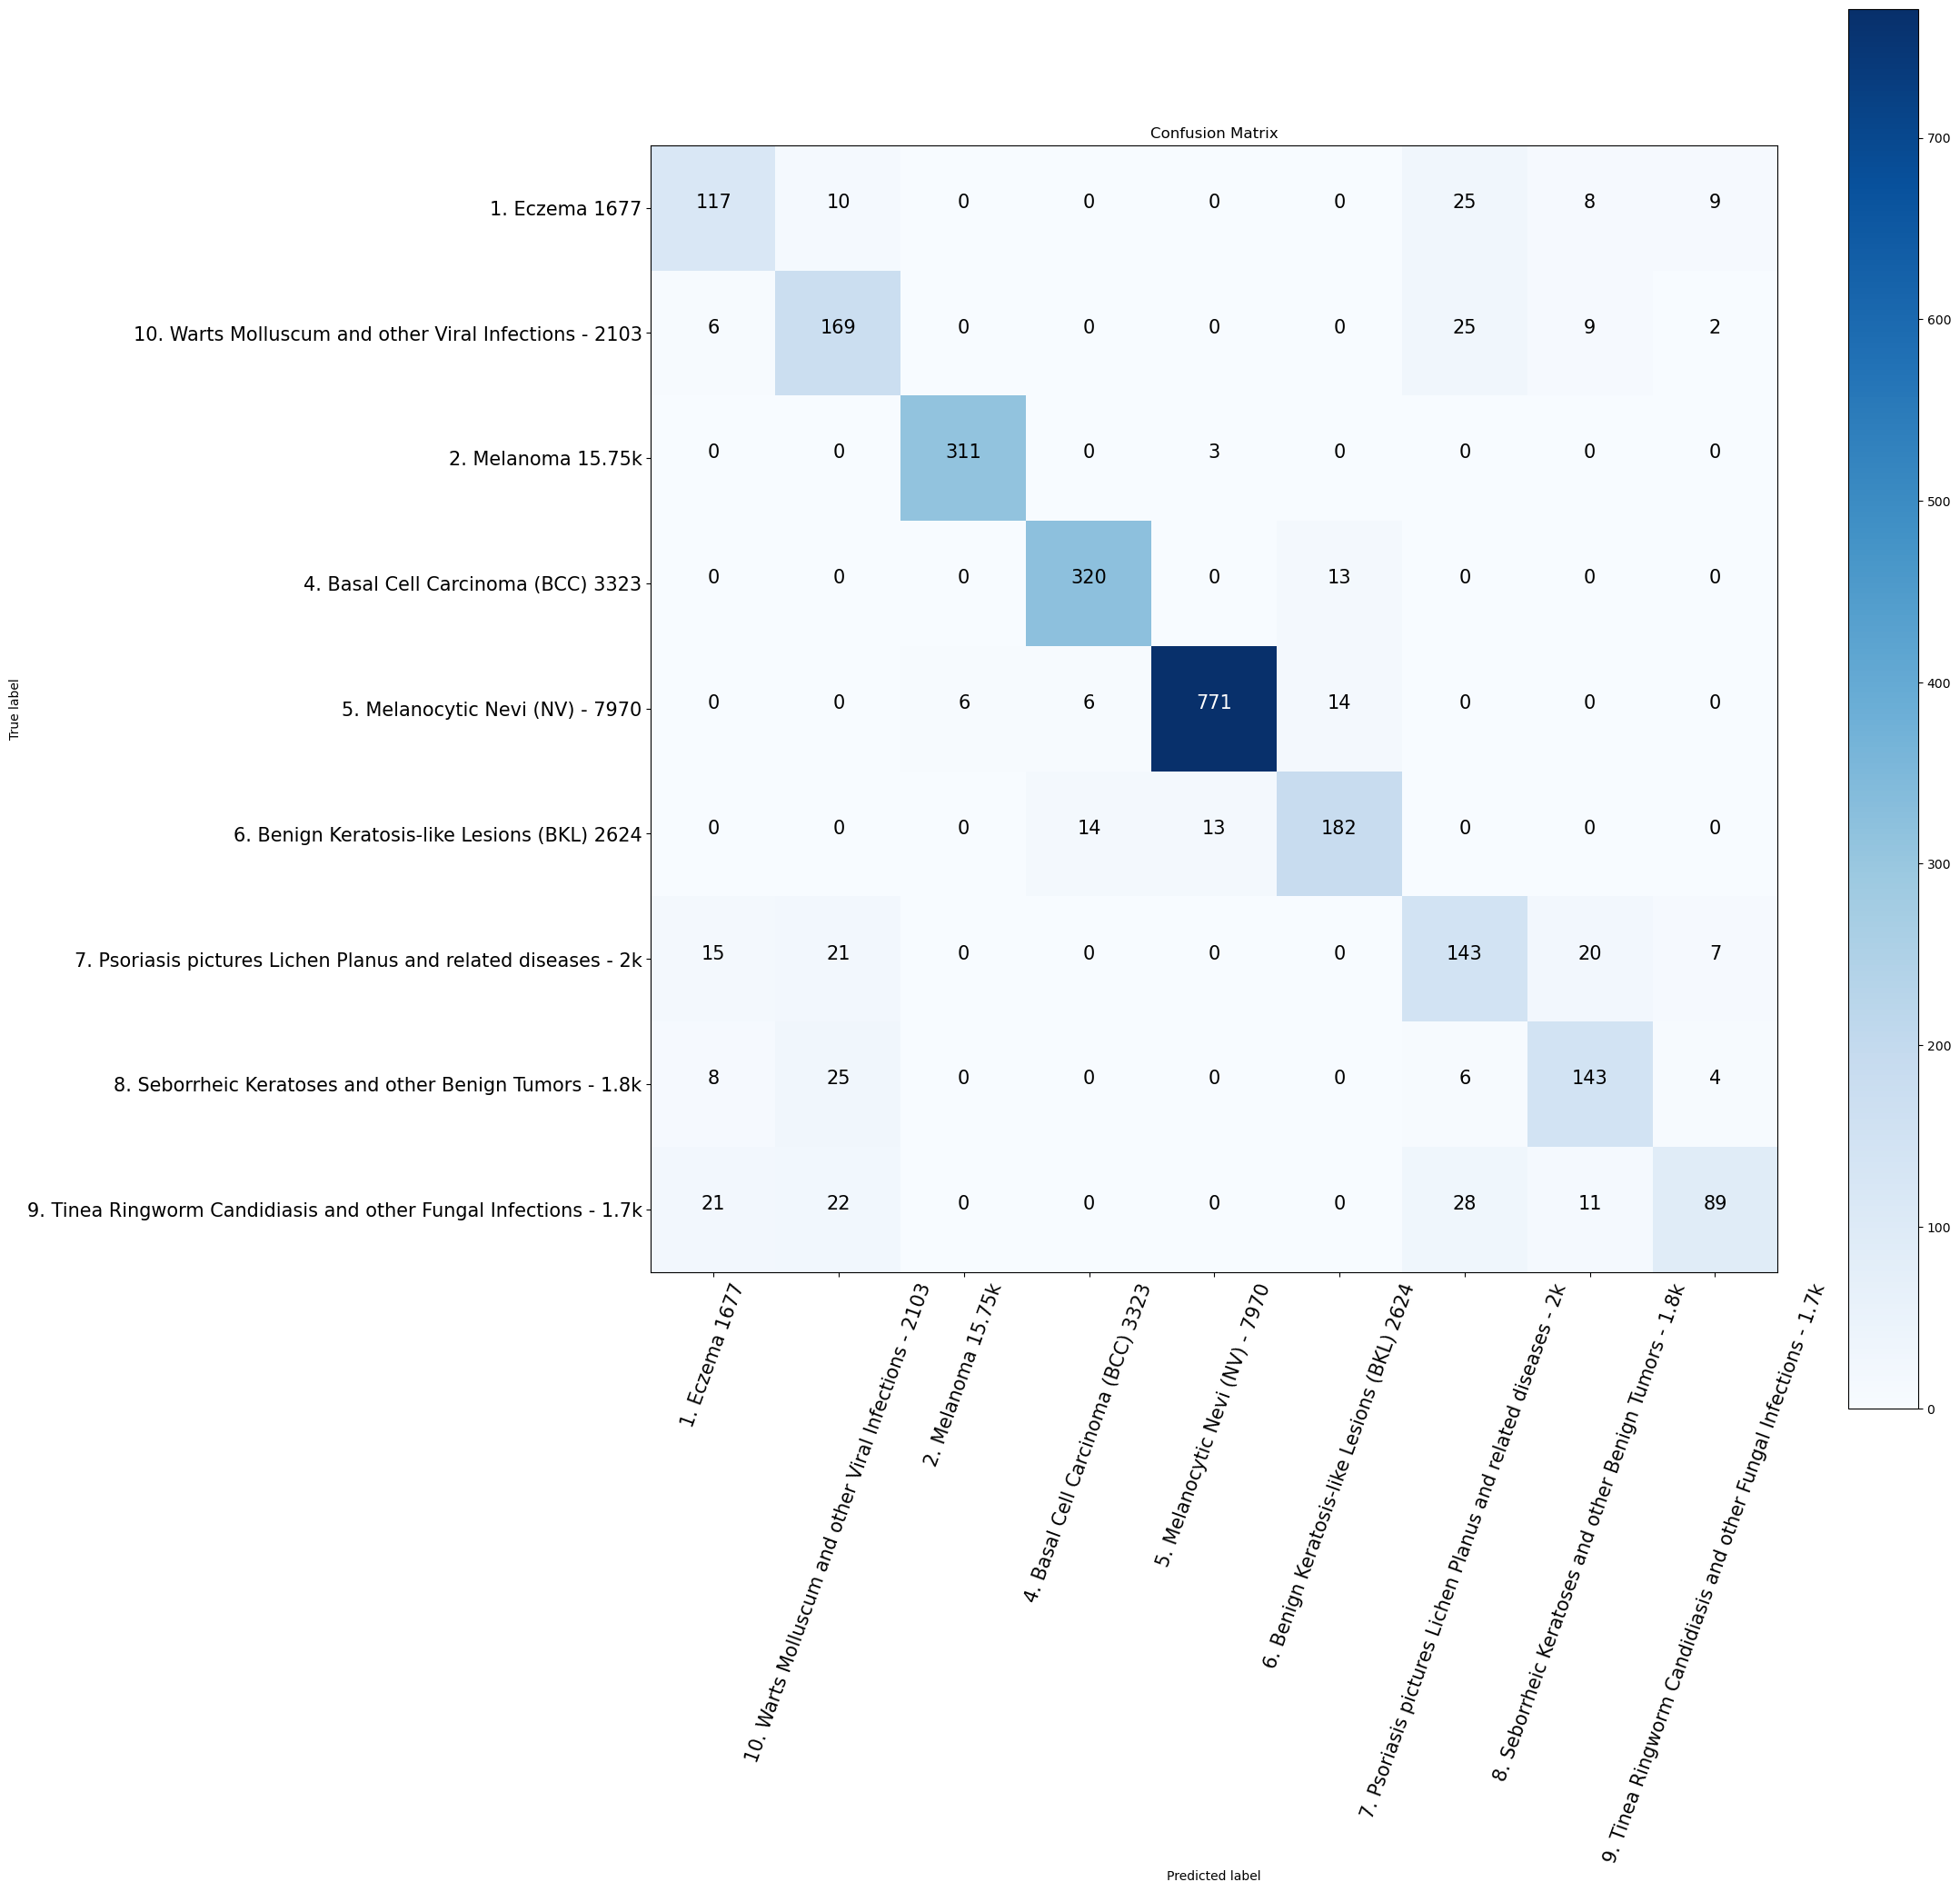

In [13]:
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (20,20))

In [14]:
subject='Skin'
save_path= r'./'
acc=87
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
model_save_loc=os.path.join(save_path, save_id)
model.save(model_save_loc)

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
"""
import joblib
from joblib import Parallel, delayed
joblib.dump(model, 'EFFNETB2_87.pkl')
"""

In [ ]:
acc=history.history["accuracy"]
loss=history.history["loss"]
val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')